Using R for supervised learning
----
    
This notebook goes over the basic concept of how to construct and use a supervised learning pipleine for classificaioon. We will use the k-nearest neighbors algorithm for illustration, but the baisc ideas carry over to all algorithms for classificaiton and regression. 

In [1]:
healthdy <- read.table('healthdy.txt', header = TRUE)

In [2]:
head(healthdy)

,ID,GENDER,FLEXPRE,FLEXPOS,BAWPRE,BAWPOS,BWWPRE,BWWPOS,BFPPRE,BFPPOS,FVCPRE,FVPOS,METSPRE,METSPOS
1,0,1,21.000,21.500,70.5,75.6,3.3,3.7,14.58,14.17,5.1,5.1,12.7,18.0
2,2,1,21.000,21.250,71.3,70.7,3.2,3.6,16.79,13.95,4.3,4.3,11.1,12.0
3,3,1,21.500,20.000,64.5,66.6,4.1,4.0,6.6,08.98,4.5,4.5,15.3,16.7
4,4,1,23.000,23.375,97,95.0,4.4,4.3,18.04,17.32,4.7,4.3,12.0,17.5
5,5,1,21.000,21.000,71,73.2,3.7,3.8,11.12,11.50,5.8,5.8,12.2,12.2
6,6,1,20.500,20.750,72.5,73.1,3.1,3.4,17.88,16.22,4.3,4.3,11.1,10.0


### Supervised learning problem

For simplicity and ease of visualization, we will just use the first 2 indepdendent variables as fearures for predicitng gender. In practice, the selection of approprieate features to use as predictors can be a challenging problem that greatly affects the effectiveness of supervised learning.

So the problme is: How accurately can we guess the gender of a student from the Flexpre and Bawpre variables? 

Visualizing the data
----

First let's make a smaller dataframe containing just the variables of interest, and make some plots.

In [3]:
df <- healthdy[,c("GENDER", "FLEXPRE", "BAWPRE")]
df$GENDER <- factor(df$GENDER)
df$FLEXPRE <- as.numeric(df$FLEXPRE)

In [4]:
summary(df)

 GENDER     FLEXPRE          BAWPRE     
 1: 82   Min.   : 1.00   Min.   :35.20  
 2:100   1st Qu.:26.00   1st Qu.:57.73  
         Median :42.00   Median :65.05  
         Mean   :38.76   Mean   :66.99  
         3rd Qu.:52.00   3rd Qu.:74.50  
         Max.   :67.00   Max.   :98.50  

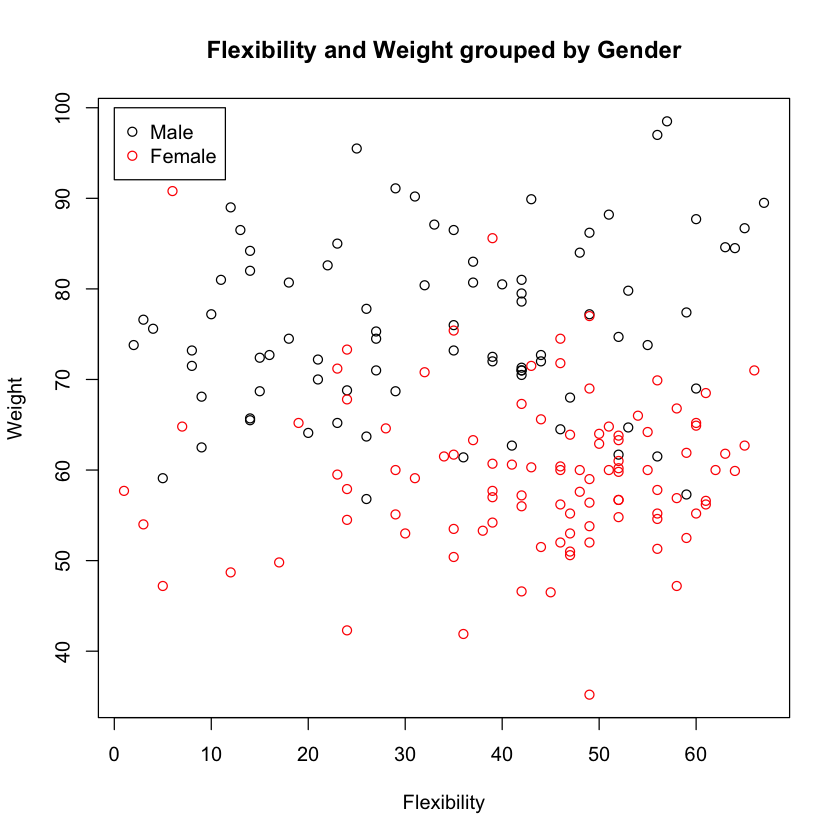

In [26]:
plot(df$FLEXPRE, df$BAWPRE, col=df$GENDER,
     xlab="Flexibility", ylab="Weight", 
     main="Flexibility and Weight grouped by Gender")
legend(0, 100, c("Male", "Female"), pch=1, col=1:2)

### Comments

It looks like there is a pretty good probablility that we can guess the gender from the body weight and flexibilty alone. The k-nearest neighbor does this guessing in a very simple fashion - Given any point in the data set, it looks for the nearest k neighboring points, and simply uses the majority gender among these neighbors as the guess. In the sections below, we'll implement a supervised learnign pipeline using k-nearest neighbors.